# Decision Tree

## Imports Section

In [99]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
import warnings

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2, SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from pickle import dump

warnings.filterwarnings('ignore')

## Initial Exploration

In [36]:
data = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [38]:
data.shape

(768, 9)

In [39]:
for un in data.columns:
    if len(data[un].unique()) < 20:
        print(un, data[un].unique())
    else:
        print(un, len(data[un].unique()))

Pregnancies [ 6  1  8  0  5  3 10  2  4  7  9 11 13 15 17 12 14]
Glucose 136
BloodPressure 47
SkinThickness 51
Insulin 186
BMI 248
DiabetesPedigreeFunction 517
Age 52
Outcome [1 0]


In [40]:
data[data.duplicated()]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [41]:
len(data[data.isna().any(axis=1)])


0

In [42]:
col_categorization = {
    'numeric': [
        'Pregnancies', 
        'Glucose', 
        'BloodPressure', 
        'SkinThickness', 
        'Insulin', 
        'BMI', 
        'DiabetesPedigreeFunction',
        'Age',
        'Outcome'
    ],
    'categorical': [],
}

target = 'Outcome'

## Exploratory Data Analysis

<Axes: xlabel='Outcome', ylabel='Count'>

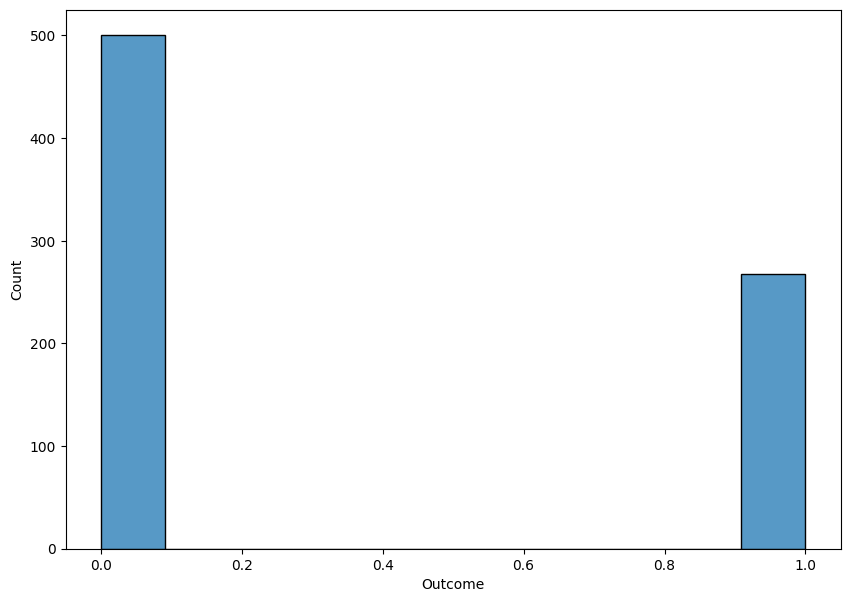

In [43]:
fig = plt.figure(figsize=(10,7))

sns.histplot(data=data, x = 'Outcome')

* Around 500 people out of the 700-ish people don't have Diabetes.
* Most people are healthy in that specific sense

In [44]:
data.shape

(768, 9)

In [45]:
data['Pregnancies'].describe()
data[(data['Pregnancies']<3) & (data['Pregnancies']>0)].shape
# 768 - 100%
# 349
# 424

(374 * 100)/768

48.697916666666664

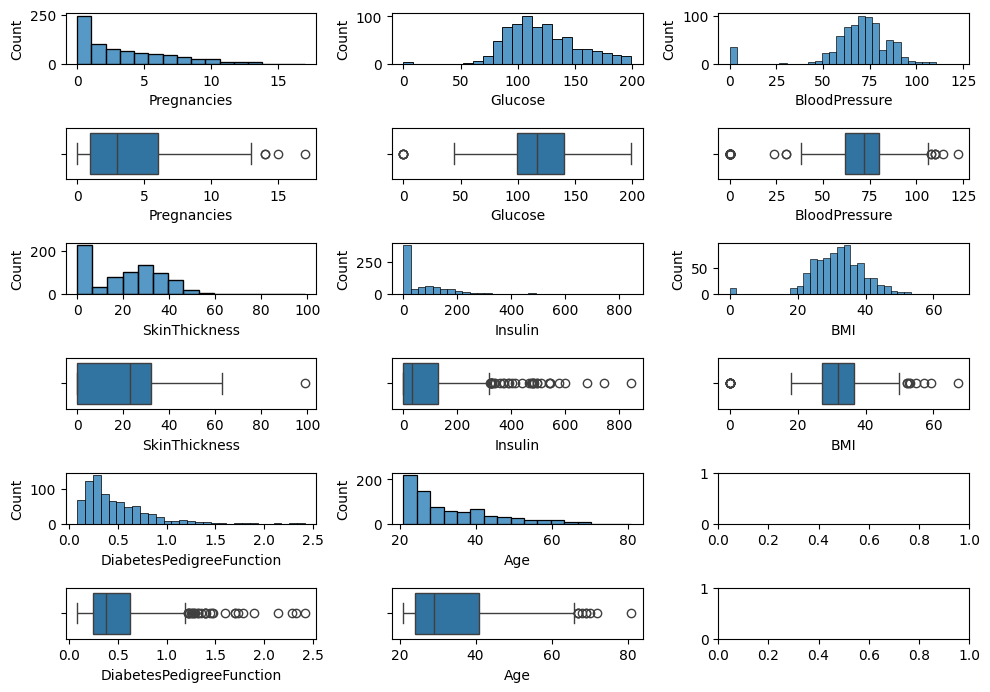

In [46]:
fig, axis = plt.subplots(6, 3, figsize=(10,7))

sns.histplot(data=data, ax=axis[0,0], x = 'Pregnancies')
sns.boxplot(data=data, x='Pregnancies', ax = axis[1,0])
sns.histplot(data=data, ax=axis[0,1], x = 'Glucose')
sns.boxplot(data=data, x='Glucose', ax = axis[1,1])
sns.histplot(data=data, ax=axis[0,2], x = 'BloodPressure')
sns.boxplot(data=data, x='BloodPressure', ax = axis[1,2])

sns.histplot(data=data, ax=axis[2,0], x = 'SkinThickness')
sns.boxplot(data=data, x='SkinThickness', ax = axis[3,0])
sns.histplot(data=data, ax=axis[2,1], x = 'Insulin')
sns.boxplot(data=data, x='Insulin', ax = axis[3,1])
sns.histplot(data=data, ax=axis[2,2], x = 'BMI')
sns.boxplot(data=data, x='BMI', ax = axis[3,2])

sns.histplot(data=data, ax=axis[4,0], x = 'DiabetesPedigreeFunction')
sns.boxplot(data=data, x='DiabetesPedigreeFunction', ax = axis[5,0])
sns.histplot(data=data, ax=axis[4,1], x = 'Age')
sns.boxplot(data=data, x='Age', ax = axis[5,1])

plt.tight_layout()
plt.show()

* `Pregnancies` mean is 3.84, around a 7th out of the total of patients haven't have a pregnancy, may be due to the genre of the patient(Not specified) or that they just didn't wanted yet or at all. More than half of the subjects(45.44%) haven't had more than 3 pregnancies and 30.98% of the subjects have had between 1 and 3 children.

* `Glucose` has 5 rows equal to 0, we can consider them as `NaN` and can be consider misinformation
* Most of the subjects seem to have a pretty healthy glucose levels, since we don't know the time of day or how long has passed since their last meal we could make no distintion between fasting and normal glucose levels, the only way to percieve the difference is if the Outcome column is set to True

* The range between the min and max value from the `BloodPressure` column suggest that the values are taken from the diastolic value reading
* `BloodPressure` has some values under 30, since it most certainly would mean death we can treat them as outliers

* `SkinThickness` gives no real value to the prediction, it might be used to deep dive into BMI measurements which makes it redundant. Concluding that the column can be dropped

* We can assume that the records that have `Insulin == 0` are from subjects that didn't take the test and represent 48.69% out of 100%, which may suggest a high relation between `Insulin` and `Outcome`

* `BMI` can't be 0, since we don't have neither height nor weight we can't calculate it to fill the 0 values. Just a low quantity of subject suffer of Obessity (Class III), but most of the subjects are classified as Obese at least in Class I

* `DiabetesPedigreeFunction` most people doesn't really have a lot of likelihood towards Diabetes. This might be something important to the Outcome

* `Age` most of the subjects are between 20 and 30 years old.

* **NOTES**
    * The mean value regarding fertility in 2021 was 2.32 per woman
    * Consider the following:
        * `Pregnancies`
            * A female can give birth only once per year
            * Fertility lasts about half a lifetime, from puberty to menopause
            * Pregnancy is assumed to be the whole biological process and not the number of children
            * A study said that a woman can have up to 15 pregnancies and between 15 to 30 children in a lifetime
            * The world record to the Most Prolific Mother was owned by a Russian woman that had around 27 pregnancies and around 69 children
        * `Glucose`
            * Assuming that the values are measured on Miligrams per deciliter(mg/dL) in blood
            * A **normal** glucose might be between 70 mg/dL and 100 mg/dL, but when **fasting** it can be between 100mg/dL and 125mg/dL
            * Lower than the normal levels is a condition called hypoglycemia, higher are hyperglycemia
        * `BloodPressure`
            * A normal blood pressure level is between:
                * Systolic 120
                * Diastolic 80
        * `Insulin`
            * This measurement is often part of an oral glucose tolerance test (OGTT)
            * Normal results would be:
                * Fasting (before glucose ingestion): 5-20 microU/mL
                * 2 hours after glucose ingestion: Less than 40-50 microU/mL
        * `BMI` (kg/m<sup>2</sup>)
            * Measurements
                * Underweight: BMI less than 18.5
                * Normal weight: BMI 18.5 to 24.9
                * Overweight: BMI 25 to 29.9
                * Obesity (Class I): BMI 30 to 34.9
                * Obesity (Class II): BMI 35 to 39.9
                * Obesity (Class III): BMI 40 or greater
            * BMI is not the best way to classify someone as it only considers height and weight, to classify someone more precisely into the earlier mentioned categories we would have to consider at least muscle mass and fat percentage.
        * `DiabetesPedigreeFunction` 
            * Calculates diabetes likelihood depending on the subject's age and his/her diabetic family history

In [47]:
data[data['BloodPressure']<30].shape

(36, 9)

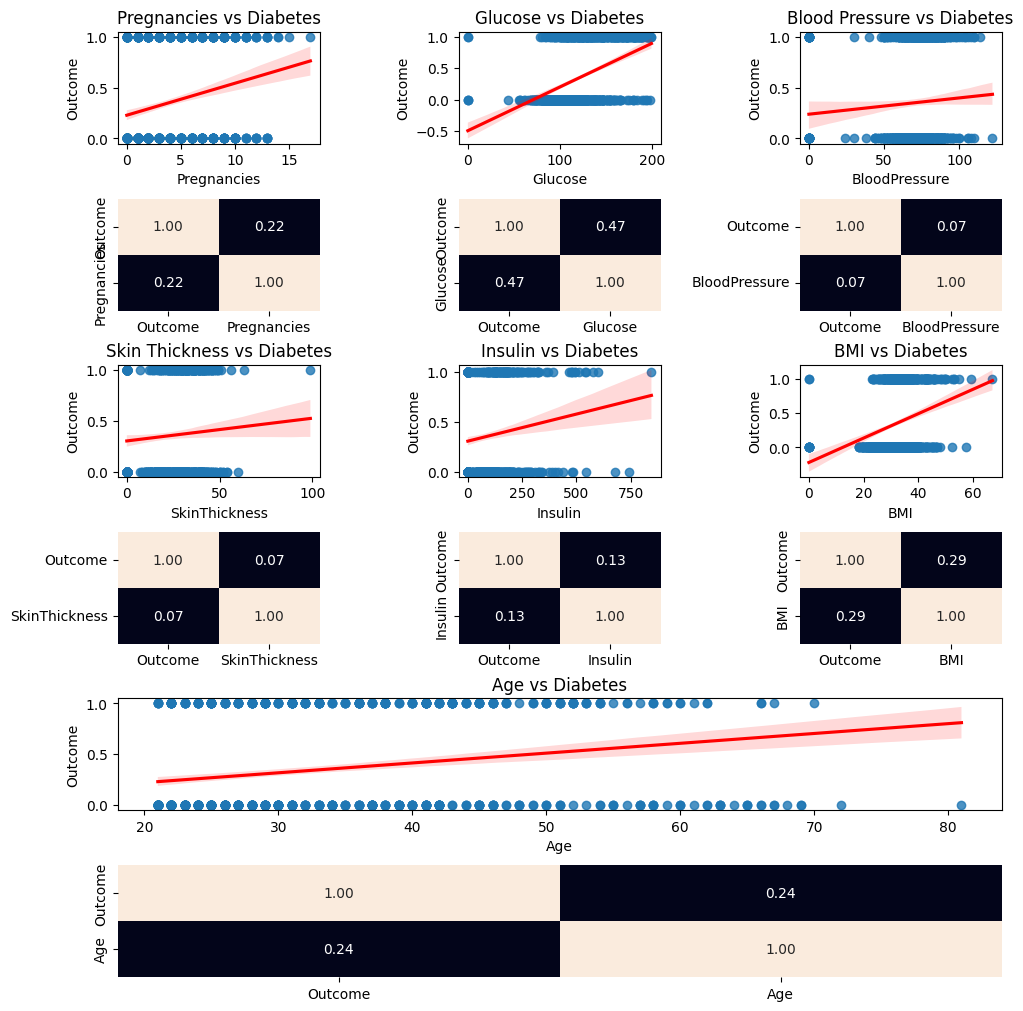

In [48]:
fig = plt.figure(
    constrained_layout = True,
    figsize = (
        10, 10
    )
)

gs = fig.add_gridspec(6,3)

################################
################################
ax00 = fig.add_subplot(
    gs[0,0]
)
ax10 = fig.add_subplot(
    gs[1,0]
)

####

ax01 = fig.add_subplot(
    gs[0,1]
)
ax11 = fig.add_subplot(
    gs[1,1]
)

####

ax02 = fig.add_subplot(
    gs[0,2]
)
ax12 = fig.add_subplot(
    gs[1,2]
)
################################
################################

ax00.set_title('Pregnancies vs Diabetes')
ax01.set_title('Glucose vs Diabetes')
ax02.set_title('Blood Pressure vs Diabetes')


sns.regplot(
    ax = ax00,
    data = data,
    x = 'Pregnancies',
    y = 'Outcome',
    line_kws = {
        'color': 'red'
    }
)
sns.heatmap(
    data[
        [
            'Outcome',
            "Pregnancies", 
        ]
    ].corr(), 
    annot = True, 
    fmt = ".2f", 
    ax=ax10, 
    cbar = False
)

sns.regplot(
    ax = ax01,
    data = data,
    x = 'Glucose',
    y = 'Outcome',
    line_kws = {
        'color': 'red'
    }
)
sns.heatmap(
    data[
        [
            'Outcome',
            "Glucose", 
        ]
    ].corr(), 
    annot = True, 
    fmt = ".2f", 
    ax=ax11, 
    cbar = False
)

sns.regplot(
    ax = ax02,
    data = data,
    x = 'BloodPressure',
    y = 'Outcome',
    line_kws = {
        'color': 'red'
    }
)
sns.heatmap(
    data[
        [
            'Outcome',
            "BloodPressure", 
        ]
    ].corr(), 
    annot = True, 
    fmt = ".2f", 
    ax=ax12, 
    cbar = False
)
################################
################################

################################
################################
ax20 = fig.add_subplot(
    gs[2,0]
)
ax30 = fig.add_subplot(
    gs[3,0]
)

###

ax21 = fig.add_subplot(
    gs[2,1]
)
ax31 = fig.add_subplot(
    gs[3,1]
)

###

ax22 = fig.add_subplot(
    gs[2,2]
)
ax32 = fig.add_subplot(
    gs[3,2]
)

################################
################################
ax20.set_title('Skin Thickness vs Diabetes')
ax21.set_title('Insulin vs Diabetes')
ax22.set_title('BMI vs Diabetes')

sns.regplot(
    ax = ax20,
    data = data,
    x = 'SkinThickness',
    y = 'Outcome',
    line_kws = {
        'color': 'red'
    }
)
sns.heatmap(
    data[
        [
            'Outcome',
            "SkinThickness", 
        ]
    ].corr(), 
    annot = True, 
    fmt = ".2f", 
    ax=ax30, 
    cbar = False
)

sns.regplot(
    ax = ax21,
    data = data,
    x = 'Insulin',
    y = 'Outcome',
    line_kws = {
        'color': 'red'
    }
)
sns.heatmap(
    data[
        [
            'Outcome',
            "Insulin", 
        ]
    ].corr(), 
    annot = True, 
    fmt = ".2f", 
    ax=ax31, 
    cbar = False
)

sns.regplot(
    ax = ax22,
    data = data,
    x = 'BMI',
    y = 'Outcome',
    line_kws = {
        'color': 'red'
    }
)
sns.heatmap(
    data[
        [
            'Outcome',
            "BMI", 
        ]
    ].corr(), 
    annot = True, 
    fmt = ".2f", 
    ax=ax32, 
    cbar = False
)

################################
################################

ax4 = fig.add_subplot(
    gs[4,:]
)
ax5 = fig.add_subplot(
    gs[5,:]
)

ax4.set_title('Age vs Diabetes')

sns.regplot(
    ax = ax4,
    data = data,
    x = 'Age',
    y = 'Outcome',
    line_kws = {
        'color': 'red'
    }
)
sns.heatmap(
    data [
        [
            'Outcome',
            'Age'
        ]
    ].corr(),
    annot = True,
    fmt = '.2f',
    ax = ax5,
    cbar = False
)

plt.show()

* All columns have some kind of positive relation with the Outcome(If they have Diabetes)
* The most significant relation is a Moderated-High relation between `Glucose` and `Outcome`, meaning that if they present a high glucose values is most likely that the have Diabetes.
* The other variables that have a Low positive relation are:
    * `Pregnancies`. Higher the number of pregnancies higher the probabilities to have Diabetes, maybe due to preeclampsia
    * `BMI`. Higher BMI higher the probability to have Diabetes
    * `Age`. Older people tend to be more prone to Diabetes, but it may not be completely related to it
* The others seem to be irrelevant to the outcome of the patient health regarding Diabetes
    * `BloodPressure`
    * `SkinThickness`
    * `Insulin`

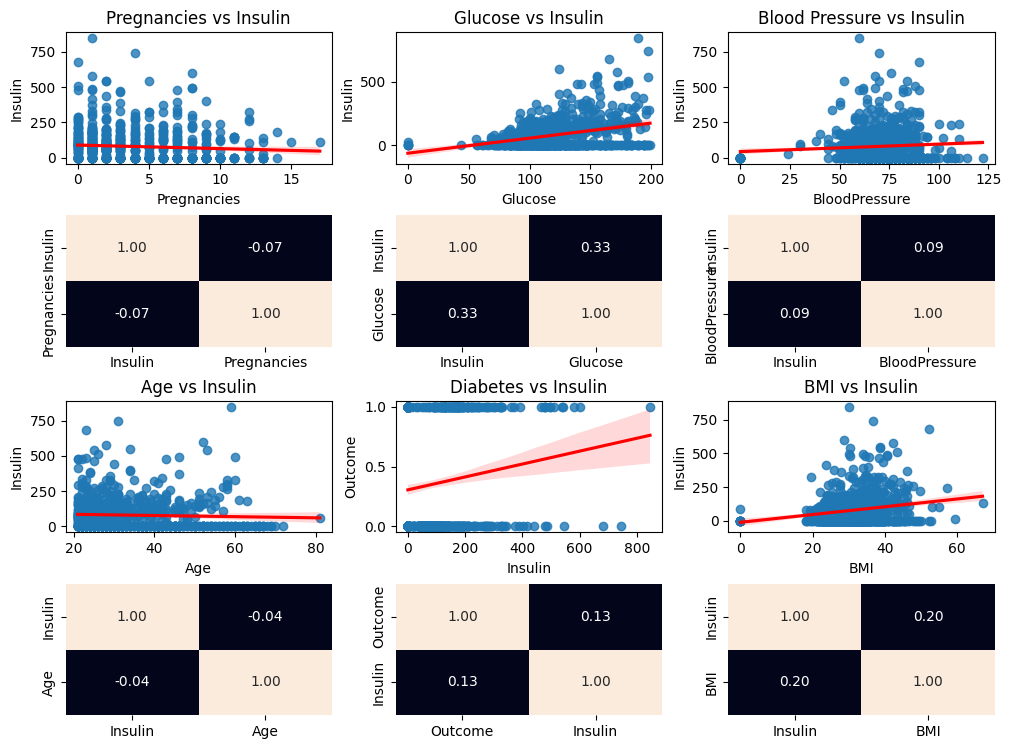

In [49]:
fig = plt.figure(
    constrained_layout = True,
    figsize = (
        10, 10
    )
)

gs = fig.add_gridspec(6,3)

################################
################################
ax00 = fig.add_subplot(
    gs[0,0]
)
ax10 = fig.add_subplot(
    gs[1,0]
)

####

ax01 = fig.add_subplot(
    gs[0,1]
)
ax11 = fig.add_subplot(
    gs[1,1]
)

####

ax02 = fig.add_subplot(
    gs[0,2]
)
ax12 = fig.add_subplot(
    gs[1,2]
)
################################
################################

ax00.set_title('Pregnancies vs Insulin')
ax01.set_title('Glucose vs Insulin')
ax02.set_title('Blood Pressure vs Insulin')


sns.regplot(
    ax = ax00,
    data = data,
    x = 'Pregnancies',
    y = 'Insulin',
    line_kws = {
        'color': 'red'
    }
)
sns.heatmap(
    data[
        [
            'Insulin',
            "Pregnancies", 
        ]
    ].corr(), 
    annot = True, 
    fmt = ".2f", 
    ax=ax10, 
    cbar = False
)

sns.regplot(
    ax = ax01,
    data = data,
    x = 'Glucose',
    y = 'Insulin',
    line_kws = {
        'color': 'red'
    }
)
sns.heatmap(
    data[
        [
            'Insulin',
            "Glucose", 
        ]
    ].corr(), 
    annot = True, 
    fmt = ".2f", 
    ax=ax11, 
    cbar = False
)

sns.regplot(
    ax = ax02,
    data = data,
    x = 'BloodPressure',
    y = 'Insulin',
    line_kws = {
        'color': 'red'
    }
)
sns.heatmap(
    data[
        [
            'Insulin',
            "BloodPressure", 
        ]
    ].corr(), 
    annot = True, 
    fmt = ".2f", 
    ax=ax12, 
    cbar = False
)
################################
################################

################################
################################
ax20 = fig.add_subplot(
    gs[2,0]
)
ax30 = fig.add_subplot(
    gs[3,0]
)

###

ax21 = fig.add_subplot(
    gs[2,1]
)
ax31 = fig.add_subplot(
    gs[3,1]
)

###

ax22 = fig.add_subplot(
    gs[2,2]
)
ax32 = fig.add_subplot(
    gs[3,2]
)

################################
################################
ax20.set_title('Age vs Insulin')
ax21.set_title('Diabetes vs Insulin')
ax22.set_title('BMI vs Insulin')

sns.regplot(
    ax = ax20,
    data = data,
    x = 'Age',
    y = 'Insulin',
    line_kws = {
        'color': 'red'
    }
)
sns.heatmap(
    data[
        [
            'Insulin',
            'Age'
        ]
    ].corr(), 
    annot = True, 
    fmt = ".2f", 
    ax=ax30, 
    cbar = False
)

sns.regplot(
    ax = ax21,
    data = data,
    x = 'Insulin',
    y = 'Outcome',
    line_kws = {
        'color': 'red'
    }
)
sns.heatmap(
    data[
        [
            'Outcome',
            "Insulin", 
        ]
    ].corr(), 
    annot = True, 
    fmt = ".2f", 
    ax=ax31, 
    cbar = False
)

sns.regplot(
    ax = ax22,
    data = data,
    x = 'BMI',
    y = 'Insulin',
    line_kws = {
        'color': 'red'
    }
)
sns.heatmap(
    data[
        [
            'Insulin',
            "BMI", 
        ]
    ].corr(), 
    annot = True, 
    fmt = ".2f", 
    ax=ax32, 
    cbar = False
)

################################
################################

plt.show()

In [50]:
insulin_more_than_0 = data[data['Insulin']>0]
insulin_more_than_0.head()



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
6,3,78,50,32,88,31.0,0.248,26,1
8,2,197,70,45,543,30.5,0.158,53,1
13,1,189,60,23,846,30.1,0.398,59,1


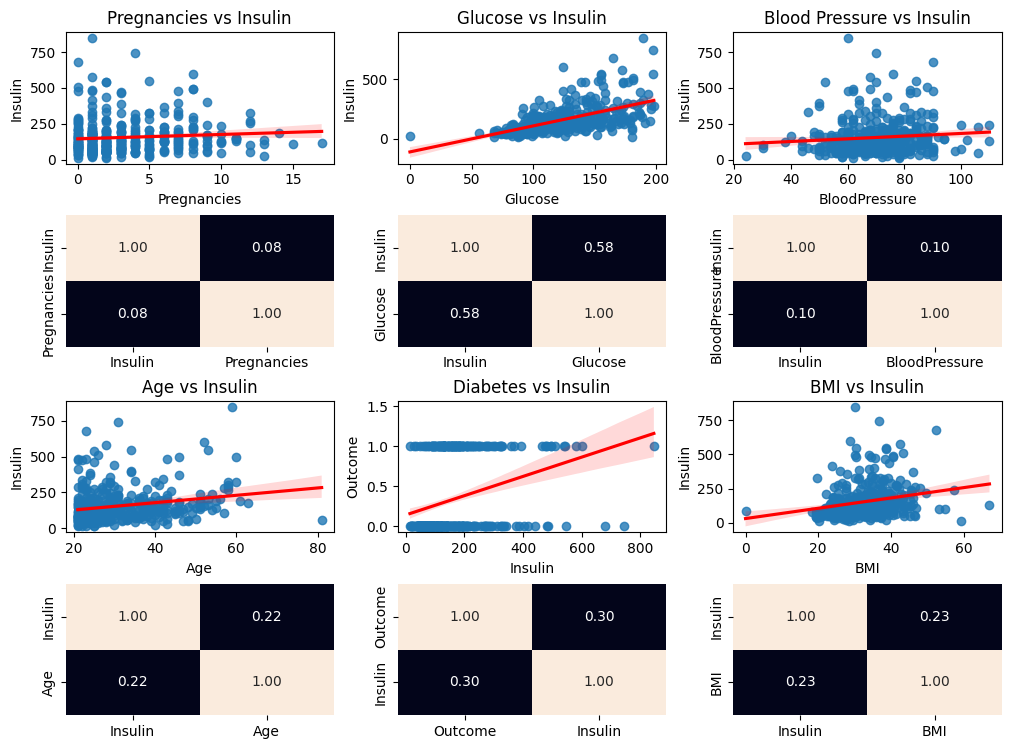

In [51]:
fig = plt.figure(
    constrained_layout = True,
    figsize = (
        10, 10
    )
)

gs = fig.add_gridspec(6,3)

################################
################################
ax00 = fig.add_subplot(
    gs[0,0]
)
ax10 = fig.add_subplot(
    gs[1,0]
)

####

ax01 = fig.add_subplot(
    gs[0,1]
)
ax11 = fig.add_subplot(
    gs[1,1]
)

####

ax02 = fig.add_subplot(
    gs[0,2]
)
ax12 = fig.add_subplot(
    gs[1,2]
)
################################
################################

ax00.set_title('Pregnancies vs Insulin')
ax01.set_title('Glucose vs Insulin')
ax02.set_title('Blood Pressure vs Insulin')


sns.regplot(
    ax = ax00,
    data = insulin_more_than_0,
    x = 'Pregnancies',
    y = 'Insulin',
    line_kws = {
        'color': 'red'
    }
)
sns.heatmap(
    insulin_more_than_0[
        [
            'Insulin',
            "Pregnancies", 
        ]
    ].corr(), 
    annot = True, 
    fmt = ".2f", 
    ax=ax10, 
    cbar = False
)

sns.regplot(
    ax = ax01,
    data = insulin_more_than_0,
    x = 'Glucose',
    y = 'Insulin',
    line_kws = {
        'color': 'red'
    }
)
sns.heatmap(
    insulin_more_than_0[
        [
            'Insulin',
            "Glucose", 
        ]
    ].corr(), 
    annot = True, 
    fmt = ".2f", 
    ax=ax11, 
    cbar = False
)

sns.regplot(
    ax = ax02,
    data = insulin_more_than_0,
    x = 'BloodPressure',
    y = 'Insulin',
    line_kws = {
        'color': 'red'
    }
)
sns.heatmap(
    insulin_more_than_0[
        [
            'Insulin',
            "BloodPressure", 
        ]
    ].corr(), 
    annot = True, 
    fmt = ".2f", 
    ax=ax12, 
    cbar = False
)
################################
################################

################################
################################
ax20 = fig.add_subplot(
    gs[2,0]
)
ax30 = fig.add_subplot(
    gs[3,0]
)

###

ax21 = fig.add_subplot(
    gs[2,1]
)
ax31 = fig.add_subplot(
    gs[3,1]
)

###

ax22 = fig.add_subplot(
    gs[2,2]
)
ax32 = fig.add_subplot(
    gs[3,2]
)

################################
################################
ax20.set_title('Age vs Insulin')
ax21.set_title('Diabetes vs Insulin')
ax22.set_title('BMI vs Insulin')

sns.regplot(
    ax = ax20,
    data = insulin_more_than_0,
    x = 'Age',
    y = 'Insulin',
    line_kws = {
        'color': 'red'
    }
)
sns.heatmap(
    insulin_more_than_0[
        [
            'Insulin',
            'Age'
        ]
    ].corr(), 
    annot = True, 
    fmt = ".2f", 
    ax=ax30, 
    cbar = False
)

sns.regplot(
    ax = ax21,
    data = insulin_more_than_0,
    x = 'Insulin',
    y = 'Outcome',
    line_kws = {
        'color': 'red'
    }
)
sns.heatmap(
    insulin_more_than_0[
        [
            'Outcome',
            "Insulin", 
        ]
    ].corr(), 
    annot = True, 
    fmt = ".2f", 
    ax=ax31, 
    cbar = False
)

sns.regplot(
    ax = ax22,
    data = insulin_more_than_0,
    x = 'BMI',
    y = 'Insulin',
    line_kws = {
        'color': 'red'
    }
)
sns.heatmap(
    insulin_more_than_0[
        [
            'Insulin',
            "BMI", 
        ]
    ].corr(), 
    annot = True, 
    fmt = ".2f", 
    ax=ax32, 
    cbar = False
)

################################
################################

plt.show()

* We would have to discuss the possibility that in the future the sample subjects either do the Insulin test, or we stop using the Insulin column for the training, since when Insulin is more than 0 the relations with Outcome and other relevant columns that affect directly the Outcome as they have a relevant positive relation with Outcome, 
* In this case, since this is a case specifically for study purposes what I'm going to do is train and optimize 2 different Decision Tree models one using the Insulin Column, and the other dropping it

In [52]:
data = data[data['Glucose']>25]
data = data[data['BMI']>15]
data = data[data['Pregnancies']<10]
data[data['BloodPressure']>30]
data.drop('SkinThickness', axis=1, inplace=True)

In [53]:
data.head()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,0,33.6,0.627,50,1
1,1,85,66,0,26.6,0.351,31,0
2,8,183,64,0,23.3,0.672,32,1
3,1,89,66,94,28.1,0.167,21,0
4,0,137,40,168,43.1,2.288,33,1


In [54]:
sklr = MinMaxScaler()

skl_fts = sklr.fit_transform(
    data[data.columns]
)

data_skl = pd.DataFrame(
    skl_fts, 
    index = data.index, 
    columns = data.columns
)
data_skl.head()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.666667,0.670968,0.590164,0.000000,0.314928,0.234415,0.483333,1.0
1,0.111111,0.264516,0.540984,0.000000,0.171779,0.116567,0.166667,0.0
2,0.888889,0.896774,0.524590,0.000000,0.104294,0.253629,0.183333,1.0
3,0.111111,0.290323,0.540984,0.111111,0.202454,0.038002,0.000000,0.0
4,0.000000,0.600000,0.327869,0.198582,0.509202,0.943638,0.200000,1.0


In [58]:
x, y = data_skl.drop('Insulin', axis = 1), data_skl['Insulin']

xtrain, xtest, ytrain, ytest = train_test_split(
    x, y,
    test_size = 0.2, 
    random_state = 42
)

model = SelectKBest(
    f_regression, k = 5
)

model.fit(
    xtrain, ytrain
)

column_selection = xtrain.columns[model.get_support()]

ft_selection_model_xtrain = pd.DataFrame(
    model.transform(
        xtrain
    ),
    columns = column_selection
)

ft_selection_model_xtest = pd.DataFrame(
    model.transform(
        xtest
    ),
    columns = column_selection
)

In [76]:
data.to_csv('../data/processed/original_df.csv', index = False)

ft_selection_model_xtrain['Insulin'] = ytrain.values
ft_selection_model_xtest['Insulin'] = ytest.values

ft_selection_model_xtrain.to_csv('../data/processed/clean_train.csv', index=False)
ft_selection_model_xtest.to_csv('../data/processed/clean_test.csv', index=False)

In [77]:
insulin_more_than_0.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
6,3,78,50,32,88,31.0,0.248,26,1
8,2,197,70,45,543,30.5,0.158,53,1
13,1,189,60,23,846,30.1,0.398,59,1


In [78]:
skl_fts_insulin_more_0 = sklr.fit_transform(
    insulin_more_than_0[insulin_more_than_0.columns]
)

data_skld_insulin_more_0 = pd.DataFrame(
    skl_fts_insulin_more_0,
    index = insulin_more_than_0.index,
    columns = insulin_more_than_0.columns
)

data_skld_insulin_more_0.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,0.058824,0.449495,0.488372,0.285714,0.096154,0.418778,0.035118,0.000000,0.0
4,0.000000,0.691919,0.186047,0.500000,0.185096,0.642325,0.943469,0.200000,1.0
6,0.176471,0.393939,0.302326,0.446429,0.088942,0.461997,0.069807,0.083333,1.0
8,0.117647,0.994949,0.534884,0.678571,0.635817,0.454545,0.031263,0.533333,1.0
13,0.058824,0.954545,0.418605,0.285714,1.000000,0.448584,0.134047,0.633333,1.0


In [79]:
x_no_0, y_no_0 = data_skld_insulin_more_0.drop('Insulin', axis = 1), data_skld_insulin_more_0['Insulin']

xtrain_no_0, xtest_no_0, ytrain_no_0, ytest_no_0 = train_test_split(
    x_no_0, y_no_0,
    test_size = 0.2,
    random_state = 42,
)

model_no_0 = SelectKBest(
    f_regression, k = 5
)

model_no_0.fit(
    xtrain_no_0, ytrain_no_0
)

col_sel = xtrain_no_0.columns[model_no_0.get_support()]

ft_sel_model_xtrain_no_0 = pd.DataFrame(
    model_no_0.transform(
        xtrain_no_0,
    ),
    columns = col_sel
)
ft_sel_model_xtest_no_0 = pd.DataFrame(
    model_no_0.transform(
        xtest_no_0,
    ),
    columns = col_sel
)

In [80]:

insulin_more_than_0.to_csv('../data/processed/df_more_than_0.csv', index=False)

ft_sel_model_xtrain_no_0['Insulin'] = ytrain_no_0.values
ft_sel_model_xtest_no_0['Insulin'] = ytest_no_0.values

ft_sel_model_xtrain_no_0.to_csv('../data/processed/clean_train_no_0.csv', index=False)
ft_sel_model_xtest_no_0.to_csv('../data/processed/clean_test_no_0.csv', index=False)

### Decision Tree Model

In [82]:
train, test = pd.read_csv("../data/processed/clean_train.csv"), pd.read_csv("../data/processed/clean_test.csv")

In [93]:
print('\t\t############################')
print('\t\t##### Insulin can be 0 #####')
print('\t\t############################\n')
print('|--------> Train <--------|')
print(train.head())

print('|--------> Test <--------|')
print(test.head())

		############################
		##### Insulin can be 0 #####
		############################

|--------> Train <--------|
    Glucose  BloodPressure       BMI  DiabetesPedigreeFunction  Outcome  \
0  0.490323       0.573770  0.505112                  0.159693      0.0   
1  0.316129       0.409836  0.214724                  0.118702      0.0   
2  0.000000       0.508197  0.139059                  0.217336      0.0   
3  0.303226       0.524590  0.224949                  0.048676      0.0   
4  0.393548       0.655738  0.292434                  0.341588      0.0   

    Insulin  
0  0.159574  
1  0.075650  
2  0.000000  
3  0.000000  
4  0.000000  
|--------> Test <--------|
    Glucose  BloodPressure       BMI  DiabetesPedigreeFunction  Outcome  \
0  0.483871       0.721311  0.554192                  0.183177      0.0   
1  0.529032       0.704918  0.188139                  0.186593      0.0   
2  0.593548       0.606557  0.159509                  0.242955      0.0   
3  0.277419     

In [95]:
xtrain, ytrain = train.drop('Insulin', axis = 1), train['Insulin']

xtest, ytest = test.drop('Insulin', axis = 1), test['Insulin']

In [97]:
DTRModel = DecisionTreeRegressor()

DTRModel.fit(
    xtrain,
    ytrain
)

DecisionTreeRegressor()

In [118]:
ypredict = DTRModel.predict(xtest)

print(f'└── Evaluation Metrics\n    ├── Mean Squared Error: {mean_squared_error(ytest, ypredict)}\n    └── R2 Score: {r2_score(ytest, ypredict)}')

└── Evaluation Metrics
    ├── Mean Squared Error: 0.04205465163606753
    └── R2 Score: -1.4739500147285063


In [119]:
train_no_0, test_no_0 = pd.read_csv('../data/processed/clean_train_no_0.csv'), pd.read_csv('../data/processed/clean_test_no_0.csv')

In [120]:
print('\t\t############################')
print('\t\t##### Insulin has no 0 #####')
print('\t\t############################\n')
print('|--------> Train <--------|')
print(train_no_0.head())

print('|--------> Test <--------|')
print(test_no_0.head())

		############################
		##### Insulin has no 0 #####
		############################

|--------> Train <--------|
    Glucose  SkinThickness       BMI       Age  Outcome   Insulin
0  0.515152       0.178571  0.436662  0.100000      0.0  0.109375
1  0.500000       0.375000  0.506706  0.150000      0.0  0.082933
2  0.479798       0.250000  0.385991  0.250000      0.0  0.070913
3  0.484848       0.107143  0.314456  0.083333      0.0  0.042067
4  0.404040       0.428571  0.509687  0.100000      1.0  0.067308
|--------> Test <--------|
    Glucose  SkinThickness       BMI       Age  Outcome   Insulin
0  0.515152       0.589286  0.554396  0.400000      0.0  0.109375
1  0.388889       0.410714  0.496274  0.050000      0.0  0.050481
2  0.797980       0.410714  0.529061  0.233333      1.0  0.377404
3  0.818182       0.875000  0.792846  0.066667      1.0  0.103365
4  0.914141       0.660714  0.645306  0.083333      1.0  0.596154


In [121]:
xtrain_no_0, ytrain_no_0 = train_no_0.drop('Insulin', axis = 1), train_no_0['Insulin']

xtest_no_0, ytest_no_0 = test_no_0.drop('Insulin', axis = 1), test_no_0['Insulin']

In [122]:
DTRModel_no_0 = DecisionTreeRegressor()

DTRModel_no_0.fit(
    xtrain_no_0, ytrain_no_0
)

DecisionTreeRegressor()

In [123]:
ypredict_no_0 = DTRModel_no_0.predict(xtest_no_0)

print(f'└── Evaluation Metrics\n    ├── Mean Squared Error: {mean_squared_error(ytest_no_0, ypredict_no_0)}\n    └── R2 Score: {r2_score(ytest_no_0, ypredict_no_0)}')

└── Evaluation Metrics
    ├── Mean Squared Error: 0.031206332273799715
    └── R2 Score: -0.476123510342394


### Model Optimization

In [125]:
print(f'''
DTRModel depth: {DTRModel.get_depth()}
DTRModel_no_0 depth: {DTRModel_no_0.get_depth()}
'''
)


DTRModel depth: 21
DTRModel_no_0 depth: 17



In [135]:
hps = {'max_depth': [2, 4, 6, 8, 10, 15, 20, None]}

metrics = {
    'has_0s': [],
    'has_no_0s': []
}

for depth in hps['max_depth']:
    has_0s = DecisionTreeRegressor(max_depth=depth).fit(xtrain, ytrain)
    has_no_0s = DecisionTreeRegressor(max_depth=depth).fit(xtrain_no_0, ytrain_no_0)
    metrics['has_0s'].append(
        (
            depth, 
            mean_squared_error(ytest, has_0s.predict(xtest)),
            r2_score(ytest, has_0s.predict(xtest))
        )
    )
    metrics['has_no_0s'].append(
        (
            depth, 
            mean_squared_error(ytest_no_0, has_no_0s.predict(xtest_no_0)),
            r2_score(ytest_no_0, has_no_0s.predict(xtest_no_0))
        )
    )

metrics['has_0s']

[(2, 0.01487788582693593, 0.12477824857048403),
 (4, 0.01876602545580601, -0.1039494359518145),
 (6, 0.018815457597940982, -0.10685738177957149),
 (8, 0.03211476349357139, -0.8892159731929412),
 (10, 0.03513950567985226, -1.067152555358843),
 (15, 0.04145180088792281, -1.4384860991037094),
 (20, 0.03367887903851256, -0.9812282364006013),
 (None, 0.03475109354697219, -1.044303425370205)]

In [146]:
for zero in metrics['has_0s']:
    print('Depth:', zero[0], '| Mean Sqr Error:', zero[1], '| R2 Score:', zero[2])
print('\n<--------------------------------------------------------------------------------------------------------->')
print('<--------------------------------------------------------------------------------------------------------->')
print('<--------------------------------------------------------------------------------------------------------->\n')
for zero in metrics['has_no_0s']:
    print('Depth:', zero[0], '| Mean Sqr Error:', zero[1], '| R2 Score:', zero[2])

Depth: 2 | Mean Sqr Error: 0.01487788582693593 | R2 Score: 0.12477824857048403
Depth: 4 | Mean Sqr Error: 0.01876602545580601 | R2 Score: -0.1039494359518145
Depth: 6 | Mean Sqr Error: 0.018815457597940982 | R2 Score: -0.10685738177957149
Depth: 8 | Mean Sqr Error: 0.03211476349357139 | R2 Score: -0.8892159731929412
Depth: 10 | Mean Sqr Error: 0.03513950567985226 | R2 Score: -1.067152555358843
Depth: 15 | Mean Sqr Error: 0.04145180088792281 | R2 Score: -1.4384860991037094
Depth: 20 | Mean Sqr Error: 0.03367887903851256 | R2 Score: -0.9812282364006013
Depth: None | Mean Sqr Error: 0.03475109354697219 | R2 Score: -1.044303425370205

<--------------------------------------------------------------------------------------------------------->
<--------------------------------------------------------------------------------------------------------->
<--------------------------------------------------------------------------------------------------------->

Depth: 2 | Mean Sqr Error: 0.0143019

In [158]:
model_0s_opt = DecisionTreeRegressor(max_depth=2).fit(xtrain, ytrain)
model_no_0_opt = DecisionTreeRegressor(max_depth=2).fit(xtrain_no_0, ytrain_no_0)

with_0_predict = model_0s_opt.predict(xtest)
no_0_predict = model_no_0_opt.predict(xtest_no_0)

final_metrics = {
    'with_0s': {
        'mse': mean_squared_error(ytest, with_0_predict),
        'r2_score': r2_score(ytest, with_0_predict)
    },
    'no_0s': {
        'mse': mean_squared_error(ytest_no_0, no_0_predict),
        'r2_score': r2_score(ytest_no_0, no_0_predict)
    },
}

print(final_metrics)
print('\n')
print(with_0_predict)
print('\n')
print(no_0_predict)

{'with_0s': {'mse': 0.01487788582693593, 'r2_score': 0.12477824857048403}, 'no_0s': {'mse': 0.014301922622899364, 'r2_score': 0.32348973145798776}}


[0.0623328  0.11345931 0.11345931 0.0623328  0.0623328  0.11345931
 0.0623328  0.0623328  0.0623328  0.0623328  0.0623328  0.21831026
 0.11345931 0.11345931 0.11345931 0.0623328  0.21831026 0.0623328
 0.0623328  0.11345931 0.21831026 0.11345931 0.11345931 0.0623328
 0.11345931 0.11345931 0.0623328  0.0623328  0.0623328  0.0623328
 0.0623328  0.0623328  0.21831026 0.0623328  0.11345931 0.21831026
 0.0623328  0.11345931 0.11345931 0.11345931 0.0623328  0.0623328
 0.11345931 0.11345931 0.11345931 0.0623328  0.0623328  0.0623328
 0.0623328  0.0623328  0.11345931 0.0623328  0.0623328  0.08796815
 0.0623328  0.0623328  0.11345931 0.0623328  0.11345931 0.0623328
 0.21831026 0.11345931 0.0623328  0.11345931 0.08796815 0.0623328
 0.0623328  0.0623328  0.21831026 0.11345931 0.0623328  0.08796815
 0.0623328  0.0623328  0.11345931 0.0623328  0.062332

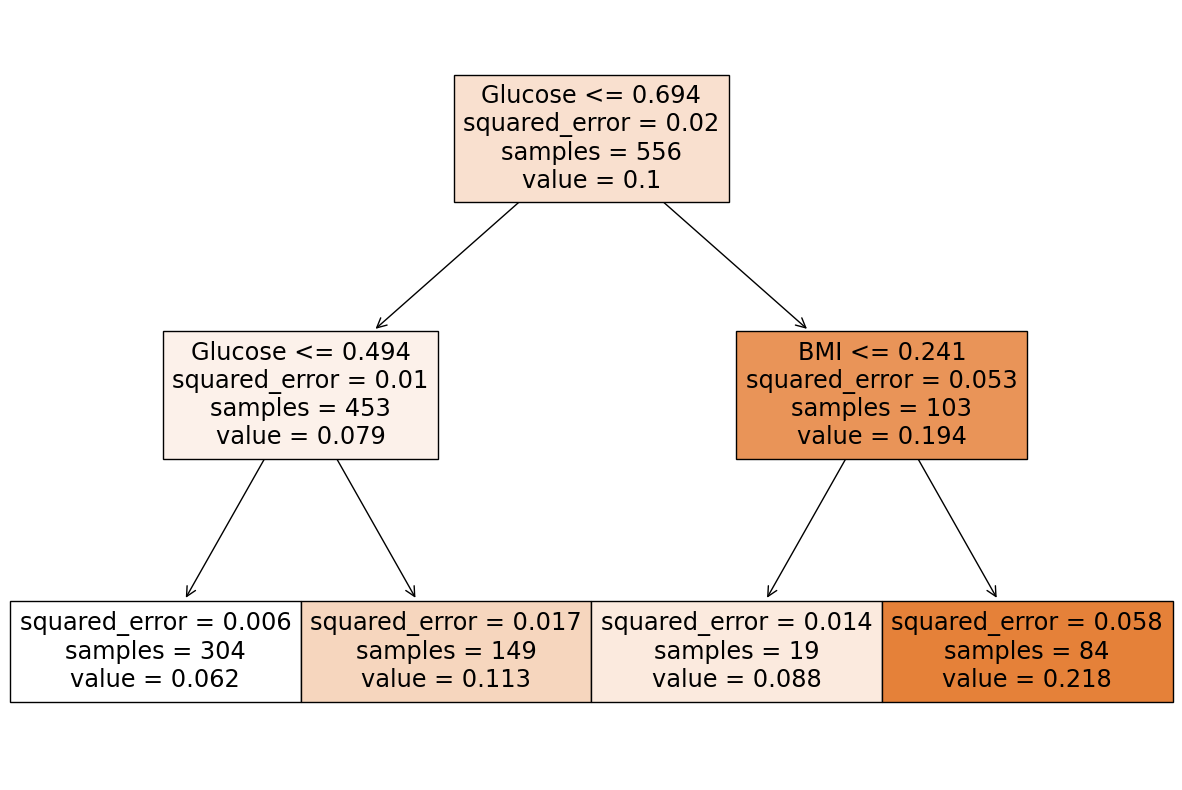

In [150]:
fig = plt.figure(figsize=(15, 10))

tree.plot_tree(model_0s_opt, feature_names = list(xtrain.columns), class_names=["0", "1", "2"], filled=True)

plt.show()

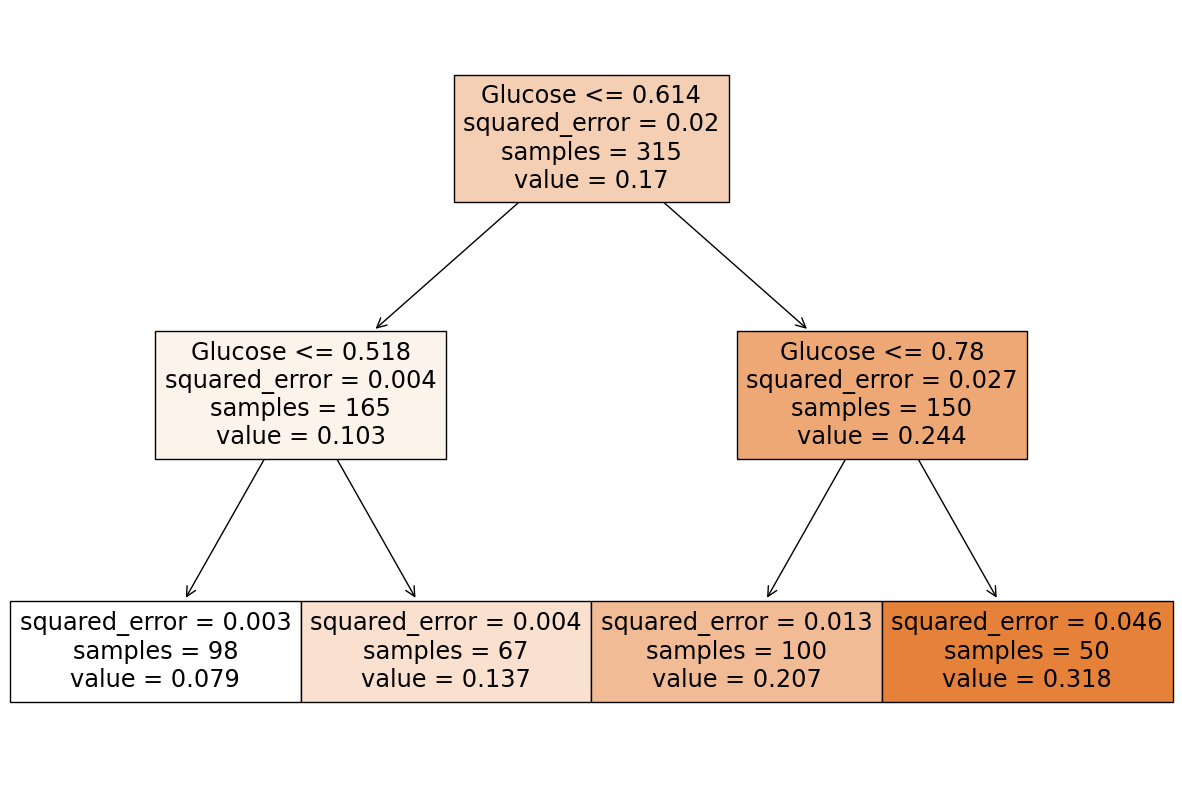

In [151]:
fig = plt.figure(figsize=(15, 10))

tree.plot_tree(model_no_0_opt, feature_names = list(xtrain.columns), class_names=["0", "1", "2"], filled=True)

plt.show()

In [149]:
dump(model_0s_opt, open("../models/tree_regressor_maxdepth-5_insulin_w-0s.sav", "wb"))
dump(model_no_0_opt, open("../models/tree_regressor_maxdepth-5_insulin_no-0s.sav", "wb"))